# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [317]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from sklearn.metrics import confusion_matrix
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [318]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [319]:
#loading dataset..
df = spark.read.json("mini_sparkify_event_data.json")

In [320]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

###### this data is realy hard to read for sure !! SOO we're going to print out THE SCHEMA ;)

In [321]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



###### LOOKS GOOD  , BUT WHAT ABOUT PRINTING OUT A TABLE ?

In [322]:
user_log.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


###### COOL

###### And now during cleaning our data we will need to checkout the number of rows , the number of columns and the number of missing values in each column !

In [323]:
user_log.count()

286500

In [324]:
print(len(user_log.columns))

18


In [325]:
user_log.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in user_log.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


###### Now let's check the activity of the user in the page 

In [326]:
user_log.groupby('page').count().toPandas()

,page,count
0,Cancel,52
1,Submit Downgrade,63
2,Thumbs Down,2546
3,Home,14457
4,Downgrade,2055
5,Roll Advert,3933
6,Logout,3226
7,Save Settings,310
8,Cancellation Confirmation,52
9,About,924


###### for now , we are 90% ready to analyze our data . BUT FIRST LET'S DELETE OUR EMPTY AND DUBLICATED VALUES TO BE COMPLETELY READY FOR ANALYSIS :*

In [327]:
df = user_log.dropna(how = "any", subset = ["userId", "sessionId"])


df.count()

286500

In [328]:
df = df.filter(df["userId"] != "")
df.count()

278154

###### here we are removing the user , the guest user and logged out user empty values .

In [329]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,50046,0,0,0,0,0,50046,0,0,0,0,0,0,50046,0,0,0,0


###### OUR DATA IS READY TO BE ANALYZED... YAAY :D 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [330]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



###### here we are going to creat a new column called churn .. :D

In [331]:
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
withchurn = df.withColumn("churn", df.userId.isin(churn_users_list))

###### And here we've provided the gender distribution between churn users and the other users

In [332]:
withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



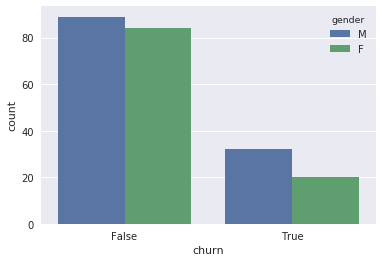

In [333]:
theRatio = withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=theRatio)

###### **Alright , so right here we can see that the ratio between males and females are relatively close but both have low number of churn users and high number of non churn users ( people that churned are less than those that did not )

#### Down there we will see the time difference between both churned and non churned Users during an hour , a day and a week


In [334]:
ghour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
withchurn = withchurn.withColumn("hour", ghour(withchurn.ts))

gweekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
withchurn = withchurn.withColumn("weekday", gweekday(withchurn.ts))

gday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
withchurn = withchurn.withColumn("day", gday(withchurn.ts))

In [335]:
def plotbychurn(time): 
    dfpd = withchurn.filter(withchurn.page == "NextSong").groupby("churn", time).count().orderBy(withchurn[time].cast("float")).toPandas()
    dfpd[time] = pd.to_numeric(dfpd[time])
    dfpd[ dfpd.churn==0].plot.bar(x=time, y='count', color='grey', label='Non churned')
    dfpd[ dfpd.churn==1].plot.bar(x=time, y='count', color='pink', label='Churned')

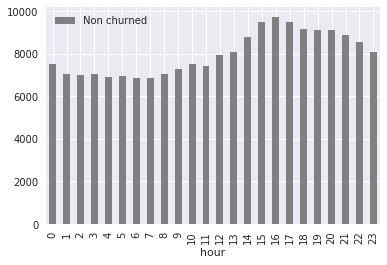

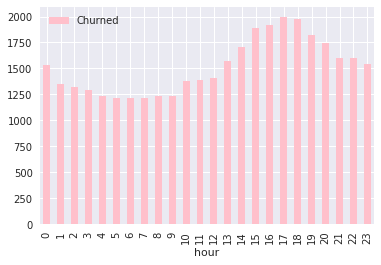

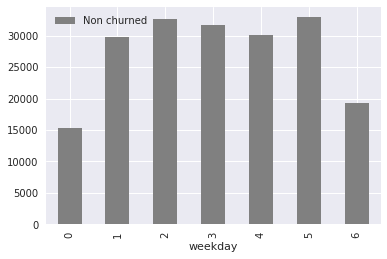

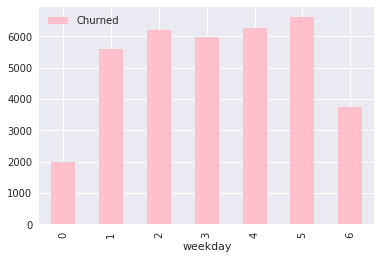

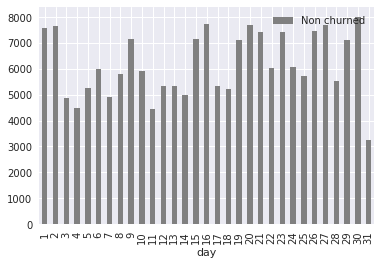

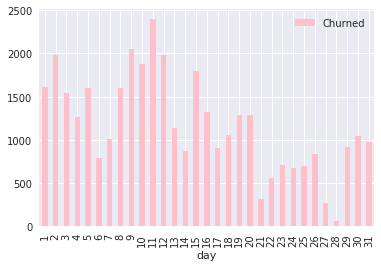

In [336]:
plotbychurn("hour")

plotbychurn("weekday")

plotbychurn("day")


### CONCLUSION :

ACCORDING TO OUR CHARTS WE CAN CLEARLY SEE THAT THERE IS A REALLY SMALL DIFFERENCE OF THE TIME IN A WEEK,AND A GREAT DIFFERENCE  OF THE TIME IN A MONTH .THE MONTHLY TIME DIFFERENCE IS MAYBE RESULTED FROM THE CONTINUOUS DISTRIBUTION IN CHURN USERS , LEADING TO A FEWER USERS AT THE END OF THE MONTH !!!

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [337]:
withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



In [338]:
print('[{}] Start'.format(datetime.datetime.now()))
print('[{}] Done'.format(datetime.datetime.now()))

[2020-04-27 04:22:18.458470] Start
[2020-04-27 04:22:18.462082] Done


In [339]:
#Removing the less useful columns
df_new = df.drop('artist', 'auth', 'firstName', 'gender',
                 'itemInSession', 'lastName', 'length', 'location', 'method', 'registration', 'sessionId', 'song', 'avg_hr')

In [340]:
df_new.toPandas().head()

,level,page,status,ts,userAgent,userId
0,paid,NextSong,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,free,NextSong,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,paid,NextSong,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,free,NextSong,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,paid,NextSong,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


###### Now we have fitted the train data

In [341]:
index_gender = StringIndexer(inputCol="gender", outputCol='index_gender')
index_page = StringIndexer(inputCol="page", outputCol='index_page')
genderVec = OneHotEncoder(inputCol='index_gender', outputCol='genderVec')
pageVec = OneHotEncoder(inputCol='index_page', outputCol='pageVec')
assembler = VectorAssembler(inputCols=["genderVec", "pageVec", "status"], outputCol="features")
index = StringIndexer(inputCol="churn", outputCol="label")

# Modeling

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize

In [345]:
train, test = df_new.randomSplit([0.8, 0.2], seed=42)

###### So here we will be Creating an object and Creating a pipeline

In [354]:
Logestic_reg=  LogisticRegression()

pipeline = Pipeline(stages=[Logestic_reg])

###### Then we will be creating a ParamGridBuilder after that we will use pipeline and paramGrid to construct a CrossValidator object ..

In [355]:
paramGrid = ParamGridBuilder() \
    .addGrid(Logestic_reg.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(Logestic_reg.regParam,[0.0, 0.01, 0.1]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

## 2ND CONCLUSION :

##### - By summering up what happened in the modeling part we can say that we've used SPARK to creat a ML Models from the LogisticRegression , CrossValidator and ParamGridBuilder to tune hyper parameters to find the best model.

##### - With respect to the results we can see that we've got the suitable and perfect models using LogisticRegression,CrossValidato in terms of accuracy and there are many other models that can definitely make much improvements .

# Final Steps

Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

### WE ARE ALL DONE , THANKS !